# 5. Evaluacion modelos de clasificacion binaria balanceo con sobremuestreo de minorías sintéticas (SMOTE), incluyendo variable ciclo
***


### Caso de estudio #1


### Tecnicas de ajuste de los datos y modelos:

| Ingeniería de datos       | Si / No     |
| :-------                  | :------:    |
| Escalado de datos         | No          |
| Ajuste de hiperparametros | Si          |
| Sobremuestreo             | Si          |
| Ajuste de pesos de clase  | No          |
| Incluye variable ciclo    | Si          |


### Cargar librerias

In [1]:
# librerias
import numpy as np
import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
import pandas_profiling
np.random.seed(9999) 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from plot_metric.functions import BinaryClassification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import classification_report

# sobremuestreo
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE




Using TensorFlow backend.


### Funciones

In [2]:
# BINARIA funcion para generar matriz de confusion y medidas de desempeño del modelos clasificacion binarios
def model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
    print('\n')
    print("MATRIZ DE CONFUSION")
    print('\n')
    matriz = confusion_matrix(label_test, label_pred)
    #print(matriz)
    classes = ["Funcional","Falla potencial"]
    cm = ConfusionMatrix(modelo, classes=classes, label_encoder={0:"Funcional", 1:"Falla Potencial"})
    cm.fit(data_train, label_train)
    cm.score(data_test, label_test)
    cm.show()
    # Medidas de desempeño del modelo
    print('\n')
    print("MEDIDAS DE DESEMPEÑO DEL MODELO")
    print('\n')
    print('Exactitud - Accuracy: {}'.format(modelo.score(data_test, label_test)))
    print('ROC AUC: {}'.format (metrics.roc_auc_score(label_test, label_pred)))
    print('-'*60)
    print('Precisión por clase: {}'.format(metrics.precision_score(label_test, label_pred, average=None)))
    print('Sensibilidad - Recall por clase: {}'.format(metrics.recall_score(label_test, label_pred, average=None)))
    print('F1 por clase: {}'.format(metrics.f1_score(label_test, label_pred, average=None)))
    print('-'*60)
    print('F1 Macro: {}'.format(metrics.f1_score(label_test, label_pred, average='macro')))
    print('F1 Micro: {}'.format(metrics.f1_score(label_test, label_pred, average='micro')))
    print('F1 Weighted: {}'.format(metrics.f1_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Sensibilidad - Recall Macro: {}'.format(metrics.recall_score(label_test, label_pred, average='macro')))
    print('Sensibilidad - Recall Micro: {}'.format(metrics.recall_score(label_test, label_pred, average='micro')))
    print('Sensibilidad - Recall Weighted: {}'.format(metrics.recall_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Precisión Macro: {}'.format(metrics.precision_score(label_test, label_pred, average='macro')))
    print('Precisión Micro: {}'.format(metrics.precision_score(label_test, label_pred, average='micro')))
    print('Precisión Weighted: {}'.format(metrics.precision_score(label_test, label_pred, average='weighted')))
    
    TP = matriz[1][1]
    TN = matriz[0][0]
    FP = matriz[0][1]
    FN = matriz[1][0]
    print('-'*60)
    print('Verdaderos positivos - True Positives:', TP)
    print('Verdaderos negativos - True Negatives:', TN)
    print('Falsos positivos - False Positives:', FP)
    print('Falsos negativos - False Negatives:', FN)
        # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
        # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
        # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
        # calculate the specificity
    conf_specificity = (TN / float(TN + FN))
        # calculate precision
    conf_precision = (TP / float(TP + FP))
        # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
        # calculate FPR tasa de falsos positivos
    conf_FPR = 1 - conf_specificity
    print('-'*60)
    print(f'Error de clasificacion: {round(conf_misclassification,3)}') 
    print(f'Especificidad - Specificity: {round(conf_specificity,3)}') 
    print(f'Tasa de falsos positivos FPR: {round(conf_FPR,3)}')
    print('-'*60)
   
    print(classification_report(label_test, label_pred))
    # curva ROC clasificacion binaria
    bc = BinaryClassification(label_test, label_pred, labels=["Class 0", "Class 1"])
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    print('\n')
    print("CURVA ROC")
    plt.show()

In [4]:
# ruta para grabar medidas de desempeño
ruta4a = "D:/alexh/Documents/Maestria en estadistica/proyecto de grado/cuadernos proyecto/Nasa Turbo Fan/Modelos 4a.xlsx"
writer = pd.ExcelWriter(ruta4a, engine='openpyxl')

### Preparar datos agil

In [5]:
columns=["id","ciclo","set1","set2","set3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]
train=pd.read_csv("train_FD001.txt",sep=" ",names=columns)
test=pd.read_csv("test_FD001.txt",sep=" ",names=columns)
rul=pd.read_csv("RUL_FD001.txt",sep=" ",header=None)
train.drop(['sensor22','sensor23'], axis=1, inplace=True)
test.drop(['sensor22','sensor23'], axis=1, inplace=True)
rul.drop([1], axis=1, inplace=True)
rul.columns = ['ttf']
rul2=pd.DataFrame(train.groupby('id')['ciclo'].max()).reset_index()
rul2.columns = ['id', 'falla']
train= train.merge(rul2, on=['id'], how='left')
train['ttf'] = train['falla'] - train['ciclo']
train.drop('falla', axis=1, inplace=True)
train['clase1']=np.where(train['ttf'] <= 30, 1, 0)
train['clase2']=train['clase1']
train.loc[train['ttf']<=15, 'clase2'] =2
rul3=pd.DataFrame(test.groupby('id')['ciclo'].max()).reset_index()
rul3.columns = ['id', 'falla']
rul['id'] = rul.index + 1
rul['falla'] = rul3['falla'] + rul['ttf']
rul.drop('ttf', axis=1, inplace=True)
test=test.merge(rul, on=['id'], how='left')
test['ttf'] = test['falla'] - test['ciclo']
test.drop('falla', axis=1, inplace=True)
test['clase1']=np.where(test['ttf'] <= 30, 1, 0)
test['clase2']=test['clase1']
test.loc[test['ttf']<=15, 'clase2'] =2

# incluyendo la variable ciclo ID
data_train=train.iloc[:,np.r_[1:26]]
label_train=train.iloc[:,27]
data_test=test.iloc[:,np.r_[1:26]]
label_test=test.iloc[:,27]
label_train2=train.iloc[:,28]
label_test2=test.iloc[:,28]



Text(0.5, 1.0, 'Funcional (0) Vs. Falla potencial (1)')

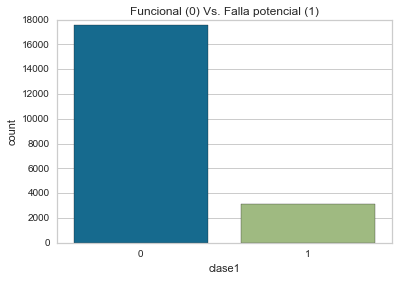

In [6]:
# conteo de observaciones por clase de la base entrenamiento
sns.countplot(label_train)
plt.title('Funcional (0) Vs. Falla potencial (1)')

In [7]:
# sobremuestreo de minorías sintéticas (SMOTE)

data_traino, label_traino = SMOTE().fit_resample(data_train, label_train)
print(sorted(Counter(label_traino).items()))

[(0, 17531), (1, 17531)]


In [8]:
label_train=pd.Series(label_traino)

Text(0.5, 1.0, 'Funcional (0) Vs. Falla potencial (1)')

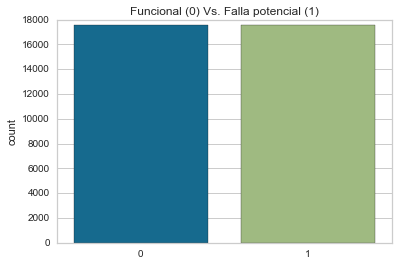

In [9]:
# grafica de base de entrenamiento equilibrada
sns.countplot(label_train)
plt.title('Funcional (0) Vs. Falla potencial (1)')

In [10]:
data_train= pd.DataFrame(data_traino, columns=data_train.columns)

In [11]:
print("numero de dimensiones =", data_train.ndim)
print("tamaño de la tabla =", data_train.shape)
print("total datos =", data_train.size)

numero de dimensiones = 2
tamaño de la tabla = (35062, 25)
total datos = 876550


In [12]:
print("numero de dimensiones =", label_train.ndim)
print("tamaño de la tabla =", label_train.shape)
print("total datos =", label_train.size)

numero de dimensiones = 1
tamaño de la tabla = (35062,)
total datos = 35062


In [13]:
data_train.head()

,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1.0,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,...,521.66,2388.02,8138.62,8.4195,0.03,392.0,2388.0,100.0,39.06,23.4190
1,2.0,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,...,522.28,2388.07,8131.49,8.4318,0.03,392.0,2388.0,100.0,39.00,23.4236
2,3.0,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,...,522.42,2388.03,8133.23,8.4178,0.03,390.0,2388.0,100.0,38.95,23.3442
3,4.0,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,...,522.86,2388.08,8133.83,8.3682,0.03,392.0,2388.0,100.0,38.88,23.3739
4,5.0,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,...,522.19,2388.04,8133.80,8.4294,0.03,393.0,2388.0,100.0,38.90,23.4044


## Modelos de clasificacion binaria balanceo con sobremuestreo de minorías sintéticas (SMOTE), incluyendo variable ciclo

## Modelo Random Forest 

In [116]:
modelo1=RandomForestClassifier(random_state=0, n_estimators=10)
modelo1.fit(data_train, label_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [117]:
label_pred1 = modelo1.predict(data_test)

In [118]:
# para evaluar cuales caracteristicas tiene mayor peso en el modelo
fi=modelo1.feature_importances_
fi

array([2.00350246e-02, 7.15217570e-03, 7.64458953e-03, 0.00000000e+00,
       0.00000000e+00, 2.12726931e-02, 1.18486184e-02, 3.28273228e-02,
       0.00000000e+00, 1.51660495e-05, 1.46694295e-01, 1.07629032e-02,
       3.06702054e-02, 0.00000000e+00, 3.15626329e-01, 8.09898307e-02,
       1.56730956e-02, 3.39586750e-02, 2.82866912e-02, 0.00000000e+00,
       9.37026413e-02, 0.00000000e+00, 0.00000000e+00, 6.95828611e-02,
       7.32568819e-02])

#### Evaluacion del modelo



MATRIZ DE CONFUSION




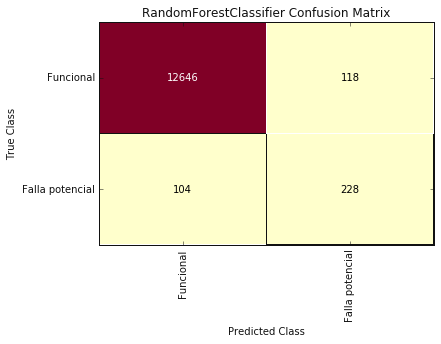



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9830482590103848
ROC AUC: 0.8387511185450043
------------------------------------------------------------
Precisión por clase: [0.99184314 0.65895954]
Sensibilidad - Recall por clase: [0.99075525 0.68674699]
F1 por clase: [0.99129889 0.67256637]
------------------------------------------------------------
F1 Macro: 0.8319326332029404
F1 Micro: 0.9830482590103848
F1 Weighted: 0.983218626119525
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8387511185450043
Sensibilidad - Recall Micro: 0.9830482590103848
Sensibilidad - Recall Weighted: 0.9830482590103848
------------------------------------------------------------
Precisión Macro: 0.8254013374135781
Precisión Micro: 0.9830482590103848
Precisión Weighted: 0.9834041211358855
------------------------------------------------------------
Verdaderos positivos - True Positives: 228
Verdaderos negativos - True Negatives: 12646
Falsos positivo

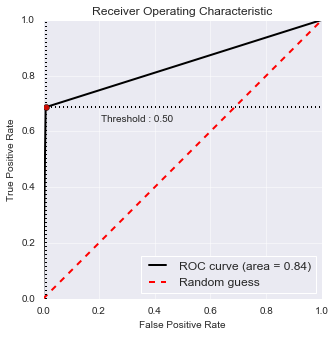

In [119]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo1, label_pred1)

In [120]:
# grabar las medidas de desempeño
report1 = classification_report(label_test, label_pred1, output_dict=True)
df = pd.DataFrame(report1).transpose()
df.to_excel(writer, sheet_name='Random Forest')
writer.save()

### Modelo Random Forest con Grid Search

In [121]:
model = RandomForestClassifier(random_state=0)
parameters= {'n_estimators': [10, 50, 100, 200, 300, 400],
             'max_features': ['log2', 'sqrt', 'auto'],
             'criterion': ['entropy', 'gini'],
             'max_depth': [2, 4, 6, 8, 10]                 
}

acc_scorer=make_scorer(accuracy_score)

grid = GridSearchCV(model, param_grid=parameters, cv=2, verbose=2, scoring=acc_scorer)
%time grid.fit(data_train, label_train)


Fitting 2 folds for each of 180 candidates, totalling 360 fits
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=10, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=10, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=50, total=   0.4s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=50 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=50, total=   0.4s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=100 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=100, total=   0.8s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=100 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=100, total=   0.7s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=200 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=200, total=   1.6s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=200 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=200, total=   1.5s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=300 
[CV]  criterion=entropy, 

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 18.5min finished


Wall time: 18min 48s


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'c

In [122]:
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_index_)

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 400}
0.964177742285095
167


In [123]:
modelo1a= grid.best_estimator_
modelo1a.fit(data_train, label_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [124]:
modelo1a= RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
modelo1a.fit(data_train, label_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [125]:
label_pred1a = modelo1a.predict(data_test)

In [126]:
# para evaluar cuales caracteristicas tiene mayor peso en el modelo
fi=modelo1a.feature_importances_
fi

array([3.73528112e-02, 3.29781926e-03, 4.30060125e-03, 0.00000000e+00,
       0.00000000e+00, 1.74435289e-02, 2.88757567e-02, 1.15567488e-01,
       0.00000000e+00, 1.36502779e-04, 8.88006392e-02, 1.51107093e-02,
       3.71097262e-02, 0.00000000e+00, 1.97937276e-01, 1.24568494e-01,
       2.03530358e-02, 3.46563167e-02, 5.41437837e-02, 0.00000000e+00,
       1.01331635e-01, 0.00000000e+00, 0.00000000e+00, 5.36351978e-02,
       6.53786774e-02])



MATRIZ DE CONFUSION




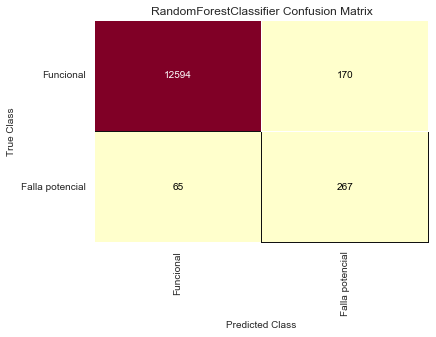



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.982055589492975
ROC AUC: 0.8954490793005931
------------------------------------------------------------
Precisión por clase: [0.99486531 0.61098398]
Sensibilidad - Recall por clase: [0.98668129 0.80421687]
F1 por clase: [0.9907564  0.69440832]
------------------------------------------------------------
F1 Macro: 0.842582362090132
F1 Micro: 0.982055589492975
F1 Weighted: 0.9832436067621644
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8954490793005931
Sensibilidad - Recall Micro: 0.982055589492975
Sensibilidad - Recall Weighted: 0.982055589492975
------------------------------------------------------------
Precisión Macro: 0.8029246474546288
Precisión Micro: 0.982055589492975
Precisión Weighted: 0.9851334407307473
------------------------------------------------------------
Verdaderos positivos - True Positives: 267
Verdaderos negativos - True Negatives: 12594
Falsos positivos - F

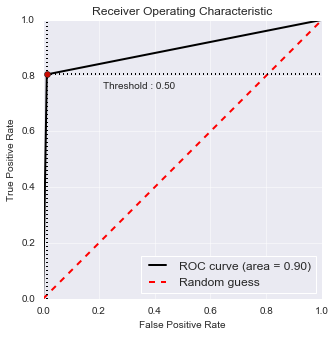

In [127]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo1a, label_pred1a)

In [128]:
report1a = classification_report(label_test, label_pred1a, output_dict=True)
df1a = pd.DataFrame(report1a).transpose()
df1a.to_excel(writer, sheet_name='Random Forest Grid')
writer.save()

## Clasificador Gausiano Naive Bayes

In [129]:
modelo2 = GaussianNB()
modelo2.fit(data_train, label_train);
label_pred2 = modelo2.predict(data_test)



MATRIZ DE CONFUSION




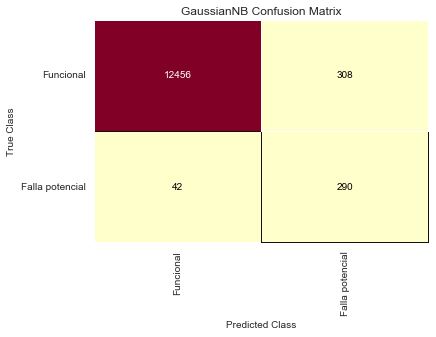



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9732742822235797
ROC AUC: 0.924681804623697
------------------------------------------------------------
Precisión por clase: [0.99663946 0.48494983]
Sensibilidad - Recall por clase: [0.97586963 0.87349398]
F1 por clase: [0.9861452  0.62365591]
------------------------------------------------------------
F1 Macro: 0.8049005561500422
F1 Micro: 0.9732742822235797
F1 Weighted: 0.9769556410215051
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9246818046236969
Sensibilidad - Recall Micro: 0.9732742822235797
Sensibilidad - Recall Weighted: 0.9732742822235797
------------------------------------------------------------
Precisión Macro: 0.740794647544945
Precisión Micro: 0.9732742822235797
Precisión Weighted: 0.9836674894209775
------------------------------------------------------------
Verdaderos positivos - True Positives: 290
Verdaderos negativos - True Negatives: 12456
Falsos positivos

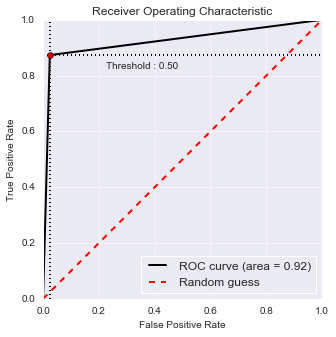

In [130]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo2, label_pred2)

In [131]:
report2 = classification_report(label_test, label_pred2, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2.to_excel(writer, sheet_name='Naive Bayes')
writer.save()

## Clasificacion con Support Vector Machine

In [132]:
modelo3 = SVC(kernel='rbf', random_state=0)
modelo3.fit(data_train, label_train)

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)

In [133]:
label_pred3 = modelo3.predict(data_test)



MATRIZ DE CONFUSION




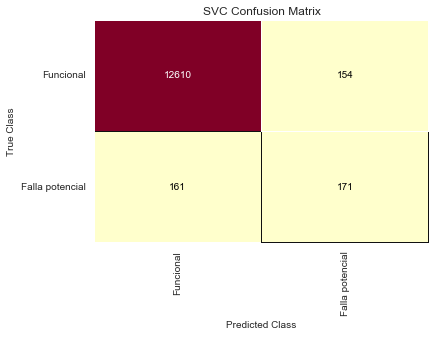



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9759468540012217
ROC AUC: 0.7514975288178725
------------------------------------------------------------
Precisión por clase: [0.98739331 0.52615385]
Sensibilidad - Recall por clase: [0.98793482 0.51506024]
F1 por clase: [0.98766399 0.52054795]
------------------------------------------------------------
F1 Macro: 0.7541059679033075
F1 Micro: 0.9759468540012217
F1 Weighted: 0.9758220138852409
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.7514975288178725
Sensibilidad - Recall Micro: 0.9759468540012217
Sensibilidad - Recall Weighted: 0.9759468540012217
------------------------------------------------------------
Precisión Macro: 0.7567735795642773
Precisión Micro: 0.9759468540012217
Precisión Weighted: 0.9757003148848696
------------------------------------------------------------
Verdaderos positivos - True Positives: 171
Verdaderos negativos - True Negatives: 12610
Falsos positiv

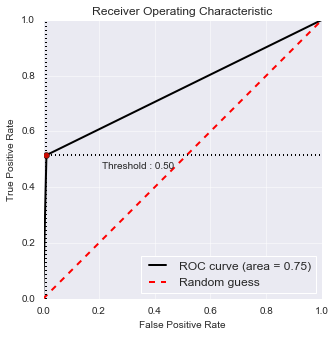

In [134]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo3, label_pred3)

In [135]:
report3 = classification_report(label_test, label_pred3, output_dict=True)
df3 = pd.DataFrame(report3).transpose()
df3.to_excel(writer, sheet_name='SVC')
writer.save()

## Clasificacion Linear SVC

In [136]:
modelo4 = LinearSVC(random_state=0, max_iter=10000)
modelo4.fit(data_train, label_train);
label_pred4 = modelo4.predict(data_test)

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)




MATRIZ DE CONFUSION




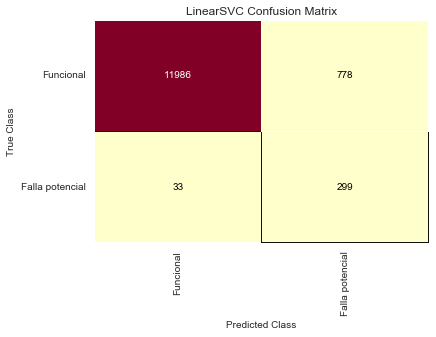



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9380726939523518
ROC AUC: 0.9198248651138556
------------------------------------------------------------
Precisión por clase: [0.99725435 0.27762303]
Sensibilidad - Recall por clase: [0.93904732 0.90060241]
F1 por clase: [0.96727596 0.42441448]
------------------------------------------------------------
F1 Macro: 0.6958452168226881
F1 Micro: 0.9380726939523518
F1 Weighted: 0.9535137370311231
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9198248651138556
Sensibilidad - Recall Micro: 0.9380726939523518
Sensibilidad - Recall Weighted: 0.9380726939523518
------------------------------------------------------------
Precisión Macro: 0.6374386871050579
Precisión Micro: 0.9380726939523518
Precisión Weighted: 0.979010792124758
------------------------------------------------------------
Verdaderos positivos - True Positives: 299
Verdaderos negativos - True Negatives: 11986
Falsos positivo

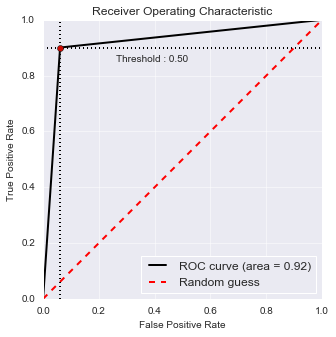

In [137]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo4, label_pred4)

In [138]:
report4 = classification_report(label_test, label_pred4, output_dict=True)
df4 = pd.DataFrame(report4).transpose()
df4.to_excel(writer, sheet_name='linearSVC')
writer.save()

## k-NN KNeighborsClassifier con grid search

In [139]:
model = KNeighborsClassifier()
parameters= {'n_neighbors': np.arange(1, 100, 2)            
}

acc_scorer=make_scorer(accuracy_score)

grid = GridSearchCV(model, param_grid=parameters, cv=5, verbose=2, scoring=acc_scorer)
%time grid.fit(data_train, label_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... n_neighbors=1, total=   0.3s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .................................... n_neighbors=1, total=   0.3s
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   0.3s
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   0.3s
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   0.3s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.3s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.3s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.3s
[CV] n_neighbors=3 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(accuracy_score), verbose=2)

In [140]:
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_index_)

{'n_neighbors': 1}
0.9638354914152073
0


In [141]:
modelo5= grid.best_estimator_
modelo5.fit(data_train, label_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [142]:
label_pred5 = modelo5.predict(data_test)



MATRIZ DE CONFUSION




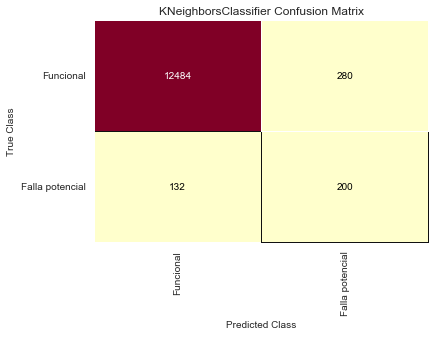



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.968540012217471
ROC AUC: 0.7902364707970081
------------------------------------------------------------
Precisión por clase: [0.9895371  0.41666667]
Sensibilidad - Recall por clase: [0.9780633  0.60240964]
F1 por clase: [0.98376675 0.49261084]
------------------------------------------------------------
F1 Macro: 0.7381887914536484
F1 Micro: 0.968540012217471
F1 Weighted: 0.9713153281302881
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.7902364707970082
Sensibilidad - Recall Micro: 0.968540012217471
Sensibilidad - Recall Weighted: 0.968540012217471
------------------------------------------------------------
Precisión Macro: 0.7031018812090467
Precisión Micro: 0.968540012217471
Precisión Weighted: 0.9750141129737742
------------------------------------------------------------
Verdaderos positivos - True Positives: 200
Verdaderos negativos - True Negatives: 12484
Falsos positivos - 

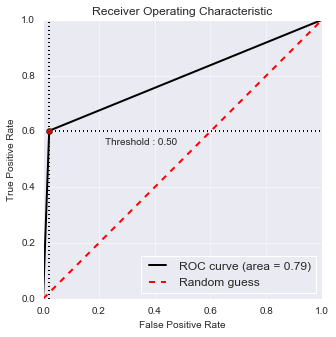

In [143]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo5, label_pred5)

In [144]:
report5 = classification_report(label_test, label_pred5, output_dict=True)
df5 = pd.DataFrame(report5).transpose()
df5.to_excel(writer, sheet_name='KNN')
writer.save()

## Clasificacion con arbol de decision con Grid Search

In [145]:
model = tree.DecisionTreeClassifier()
depths = np.arange(1,20)
parameters= {'max_depth' : depths,
             'min_samples_leaf' : [1, 5, 10, 20, 50, 100],
             'criterion': ['entropy', 'gini'],
}

acc_scorer=make_scorer(accuracy_score)

grid = GridSearchCV(model, param_grid=parameters, cv=5, verbose=2, scoring=acc_scorer)
%time grid.fit(data_train, label_train)

Fitting 5 folds for each of 228 candidates, totalling 1140 fits
[CV] criterion=entropy, max_depth=1, min_samples_leaf=1 ..............
[CV]  criterion=entropy, max_depth=1, min_samples_leaf=1, total=   0.1s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=1 ..............
[CV]  criterion=entropy, max_depth=1, min_samples_leaf=1, total=   0.1s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=1 ..............
[CV]  criterion=entropy, max_depth=1, min_samples_leaf=1, total=   0.1s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=entropy, max_depth=1, min_samples_leaf=1, total=   0.1s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=1 ..............
[CV]  criterion=entropy, max_depth=1, min_samples_leaf=1, total=   0.1s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=1, min_samples_leaf=5, total=   0.1s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=1, min_samples_leaf=5, total=   0.1s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=1, min_samples_leaf=5, total=   0.1s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=1, min_samples_leaf=5, total=   0.1s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=1, min_samples_leaf=5, total=   0.1s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=10 .............

[Parallel(n_jobs=1)]: Done 1140 out of 1140 | elapsed:  4.6min finished


Wall time: 4min 38s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8, 

In [146]:
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_index_)

{'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 1}
0.9568193485825109
90


In [147]:
modelo6= grid.best_estimator_
modelo6.fit(data_train, label_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=16,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [148]:
label_pred6 = modelo6.predict(data_test)



MATRIZ DE CONFUSION




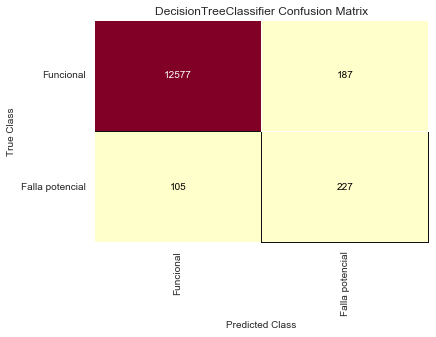



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9777031154551008
ROC AUC: 0.8345421800017369
------------------------------------------------------------
Precisión por clase: [0.99172055 0.54830918]
Sensibilidad - Recall por clase: [0.98534942 0.68373494]
F1 por clase: [0.98852472 0.60857909]
------------------------------------------------------------
F1 Macro: 0.7985519037423306
F1 Micro: 0.9777031154551008
F1 Weighted: 0.9788926214761897
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8345421800017367
Sensibilidad - Recall Micro: 0.9777031154551008
Sensibilidad - Recall Weighted: 0.9777031154551008
------------------------------------------------------------
Precisión Macro: 0.7700148637766486
Precisión Micro: 0.9777031154551008
Precisión Weighted: 0.9804795152982101
------------------------------------------------------------
Verdaderos positivos - True Positives: 227
Verdaderos negativos - True Negatives: 12577
Falsos positiv

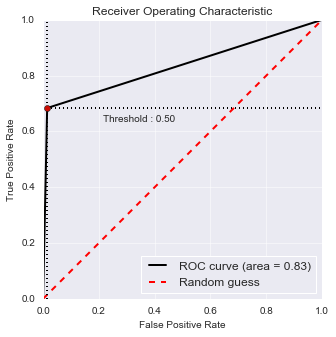

In [149]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo6, label_pred6)

In [150]:
report6 = classification_report(label_test, label_pred6, output_dict=True)
df6 = pd.DataFrame(report6).transpose()
df6.to_excel(writer, sheet_name='Tree')
writer.save()

## Clasificacion por regresion logistica con Grid Search

In [151]:
model = LogisticRegression(solver='liblinear')
c = np.arange(1,20)
parameters= {'C' : c,}

acc_scorer=make_scorer(accuracy_score)

grid = GridSearchCV(model, param_grid=parameters, cv=5, verbose=2, scoring=acc_scorer)
%time grid.fit(data_train, label_train)

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................................. C=1, total=   0.5s
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .............................................. C=1, total=   0.8s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.7s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.8s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.7s
[CV] C=2 .............................................................
[CV] .............................................. C=2, total=   0.6s
[CV] C=2 .............................................................
[CV] .............................................. C=2, total=   0.6s
[CV] C=2 .............................................................
[CV] .............................................. C=2, total=   0.6s
[CV] C=2 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:  1.1min finished


Wall time: 1min 9s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(accuracy_score), verbose=2)

In [152]:
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_index_)

{'C': 19}
0.9482630768353203
18


In [153]:
modelo7= grid.best_estimator_
modelo7.fit(data_train, label_train)

LogisticRegression(C=19, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [154]:
label_pred7 = modelo7.predict(data_test)



MATRIZ DE CONFUSION




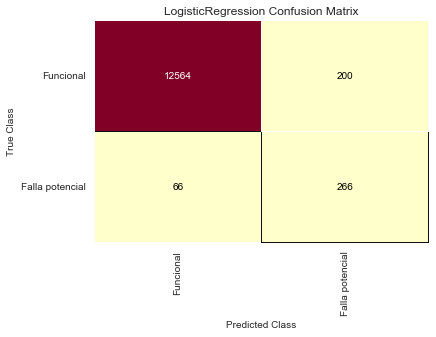



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9796884544899206
ROC AUC: 0.8927678750099112
------------------------------------------------------------
Precisión por clase: [0.99477435 0.57081545]
Sensibilidad - Recall por clase: [0.98433093 0.80120482]
F1 por clase: [0.98952508 0.66666667]
------------------------------------------------------------
F1 Macro: 0.8280958756661678
F1 Micro: 0.9796884544899206
F1 Weighted: 0.9813402194567756
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8927678750099111
Sensibilidad - Recall Micro: 0.9796884544899206
Sensibilidad - Recall Weighted: 0.9796884544899206
------------------------------------------------------------
Precisión Macro: 0.782794898718563
Precisión Micro: 0.9796884544899206
Precisión Weighted: 0.9840264578561426
------------------------------------------------------------
Verdaderos positivos - True Positives: 266
Verdaderos negativos - True Negatives: 12564
Falsos positivo

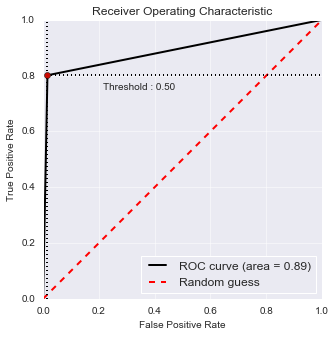

In [155]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, modelo7, label_pred7)

In [156]:
report7 = classification_report(label_test, label_pred7, output_dict=True)
df7 = pd.DataFrame(report7).transpose()
df7.to_excel(writer, sheet_name='LogisticR')
writer.save()

## Clasificacion con red neuronal MLP

In [157]:
modelo8= MLPClassifier(random_state=0)
modelo8.fit(data_train, label_train);
label_pred8 = modelo8.predict(data_test)




MATRIZ DE CONFUSION




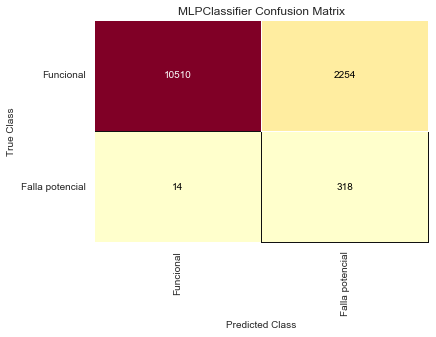



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.8268173488087965
ROC AUC: 0.8906204573857951
------------------------------------------------------------
Precisión por clase: [0.99866971 0.12363919]
Sensibilidad - Recall por clase: [0.82340959 0.95783133]
F1 por clase: [0.90261079 0.21900826]
------------------------------------------------------------
F1 Macro: 0.5608095255670285
F1 Micro: 0.8268173488087965
F1 Weighted: 0.8852806066641303
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8906204573857952
Sensibilidad - Recall Micro: 0.8268173488087965
Sensibilidad - Recall Weighted: 0.8268173488087965
------------------------------------------------------------
Precisión Macro: 0.5611544493132191
Precisión Micro: 0.8268173488087965
Precisión Weighted: 0.9764865879612347
------------------------------------------------------------
Verdaderos positivos - True Positives: 318
Verdaderos negativos - True Negatives: 10510
Falsos positiv

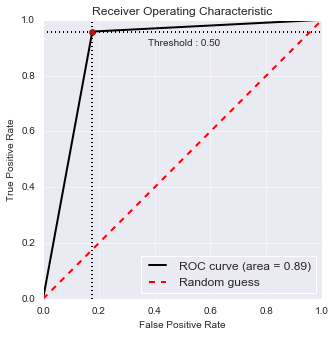

In [158]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo8, label_pred8)

In [159]:
report8 = classification_report(label_test, label_pred8, output_dict=True)
df8 = pd.DataFrame(report8).transpose()
df8.to_excel(writer, sheet_name='MLP')
writer.save()

## Red neronal MLP con grid search

In [160]:
model = MLPClassifier(random_state=0)

parameters= {'learning_rate':["constant", "invscaling", "adaptive"],
             'hidden_layer_sizes':[(8),(2,4),(1,8,1),(1,1,1),(2,8,2),(4,16,4), (1,2,1)],
             'activation': ["identity","logistic", "relu", "tanh"],
             'solver': ["lbfgs", "sgd", "adam"]
}

acc_scorer=make_scorer(accuracy_score)

grid = GridSearchCV(model, param_grid=parameters, cv=2, verbose=2, scoring=acc_scorer)
%time grid.fit(data_train, label_train)


Fitting 2 folds for each of 252 candidates, totalling 504 fits
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=sgd 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=sgd, total=   3.1s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=sgd, total=   3.0s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=adam, total=   0.5s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=constant, solver=adam, total=   1.9s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=sgd, total=   3.2s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=sgd, total=   3.2s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=adam, total=   0.5s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=invscaling, solver=adam, total=   2.0s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=sgd, total=   3.2s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=sgd, total=   3.1s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=adam, total=   0.5s
[CV] activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=8, learning_rate=adaptive, solver=adam, total=   1.9s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=sgd, total=   3.8s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=sgd, total=   3.9s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=sgd, total=   3.8s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=sgd, total=   3.7s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=sgd, total=   3.7s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=sgd, total=   3.9s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 4), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=sgd, total=   4.4s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=sgd, total=   4.3s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=adam, total=   5.2s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=constant, solver=adam, total=   1.9s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscal

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscaling, solver=sgd, total=   4.3s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscaling, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscaling, solver=sgd, total=   4.3s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscaling, solver=adam, total=   5.3s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=invscaling, solver=adam, total=   1.9s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adapt

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adaptive, solver=sgd, total=   4.3s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adaptive, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adaptive, solver=sgd, total=   4.4s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adaptive, solver=adam, total=   5.1s
[CV] activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 8, 1), learning_rate=adaptive, solver=adam, total=   1.9s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solve

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solver=sgd, total=   3.5s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solver=sgd, total=   3.4s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscal

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscaling, solver=sgd, total=   3.5s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscaling, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscaling, solver=sgd, total=   3.5s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adapt

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adaptive, solver=sgd, total=   3.4s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adaptive, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adaptive, solver=sgd, total=   3.5s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 1, 1), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solve

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solver=sgd, total=   4.6s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solver=sgd, total=   4.7s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solver=adam, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=constant, solver=adam, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscal

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscaling, solver=sgd, total=   4.6s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscaling, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscaling, solver=sgd, total=   4.7s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscaling, solver=adam, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=invscaling, solver=adam, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adapt

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adaptive, solver=sgd, total=   4.6s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adaptive, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adaptive, solver=sgd, total=   4.5s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adaptive, solver=adam, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 8, 2), learning_rate=adaptive, solver=adam, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, solver=lbfgs, total=   0.2s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, 

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, solver=sgd, total=   4.9s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, solver=sgd, total=   5.0s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, solver=adam, total=   1.7s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=constant, solver=adam, total=   1.8s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=invscaling, solver=lbfgs, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=invscaling, solver=lbfgs, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_ra

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=invscaling, solver=sgd, total=   5.0s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=invscaling, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=invscaling, solver=sgd, total=   5.0s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=invscaling, solver=adam, total=   1.8s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=invscaling, solver=adam, total=   1.7s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=adaptive, solver=sgd, total=   4.7s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=adaptive, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=adaptive, solver=sgd, total=   5.0s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=adaptive, solver=adam, total=   1.7s
[CV] activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(4, 16, 4), learning_rate=adaptive, solver=adam, total=   1.8s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, 

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, solver=sgd, total=   4.2s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, solver=sgd, total=   4.3s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, solver=adam, total=   1.0s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=constant, solver=adam, total=   1.0s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscal

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscaling, solver=sgd, total=   4.2s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscaling, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscaling, solver=sgd, total=   4.1s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscaling, solver=adam, total=   1.0s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=invscaling, solver=adam, total=   1.0s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adapt

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adaptive, solver=sgd, total=   4.1s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adaptive, solver=sgd 


C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:749: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adaptive, solver=sgd, total=   4.1s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adaptive, solver=adam, total=   1.0s
[CV] activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 2, 1), learning_rate=adaptive, solver=adam, total=   1.0s
[CV] activation=logistic, hidden_layer_sizes=8, learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=8, learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=logistic, hidden_layer_sizes=8, learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=8, learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=logistic, hidden_layer_sizes=8, learning_rate=constant, solver=sgd 
[CV]  activation=logistic, hidden

[Parallel(n_jobs=1)]: Done 504 out of 504 | elapsed:  7.3min finished


Wall time: 7min 20s


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_sta...
             iid='warn', n_jobs=None,
             param_grid={'activation': ['identity', 'logistic', 'relu', 'tanh'],
                         'hidden_layer_sizes': [8, (2, 4), (1, 8, 1), (1, 1, 1),
                                                (2, 8, 2), (4, 16, 4),
                                                (

In [161]:
modelo9= grid.best_estimator_
modelo9.fit(data_train, label_train)

MLPClassifier(activation='identity', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(2, 8, 2), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [162]:
label_pred9 = modelo9.predict(data_test)



MATRIZ DE CONFUSION




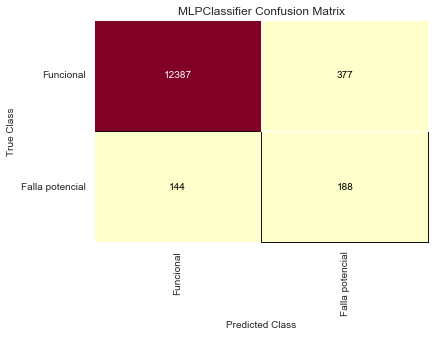



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9602168601099572
ROC AUC: 0.7683644323454897
------------------------------------------------------------
Precisión por clase: [0.9885085  0.33274336]
Sensibilidad - Recall por clase: [0.9704638  0.56626506]
F1 por clase: [0.97940304 0.41917503]
------------------------------------------------------------
F1 Macro: 0.6992890359752688
F1 Micro: 0.9602168601099572
F1 Weighted: 0.965200562300578
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.7683644323454898
Sensibilidad - Recall Micro: 0.9602168601099572
Sensibilidad - Recall Weighted: 0.9602168601099572
------------------------------------------------------------
Precisión Macro: 0.6606259308772651
Precisión Micro: 0.9602168601099572
Precisión Weighted: 0.9718840315141386
------------------------------------------------------------
Verdaderos positivos - True Positives: 188
Verdaderos negativos - True Negatives: 12387
Falsos positivo

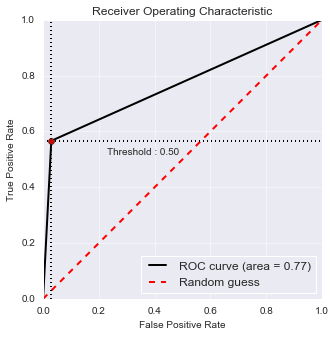

In [163]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo9, label_pred9)

In [164]:
report9 = classification_report(label_test, label_pred9, output_dict=True)
df9 = pd.DataFrame(report9).transpose()
df9.to_excel(writer, sheet_name='MLP 8')
writer.save()

## Bagging Classifier

In [14]:
modelo8= BaggingClassifier(random_state=0)
modelo8.fit(data_train, label_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=0, verbose=0,
                  warm_start=False)



MATRIZ DE CONFUSION




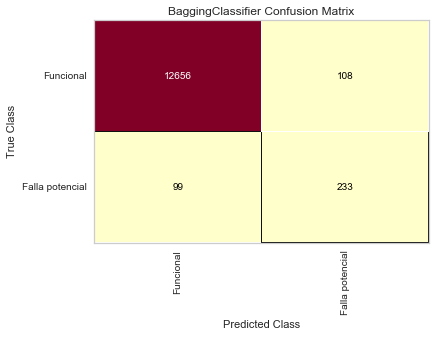



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9841936469150886
ROC AUC: 0.846672965758364
------------------------------------------------------------
Precisión por clase: [0.99223834 0.68328446]
Sensibilidad - Recall por clase: [0.9915387  0.70180723]
F1 por clase: [0.9918884  0.69242199]
------------------------------------------------------------
F1 Macro: 0.8421551939827254
F1 Micro: 0.9841936469150886
F1 Weighted: 0.9842965484748079
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.846672965758364
Sensibilidad - Recall Micro: 0.9841936469150886
Sensibilidad - Recall Weighted: 0.9841936469150886
------------------------------------------------------------
Precisión Macro: 0.8377613976923546
Precisión Micro: 0.9841936469150886
Precisión Weighted: 0.9844059701377411
------------------------------------------------------------
Verdaderos positivos - True Positives: 233
Verdaderos negativos - True Negatives: 12656
Falsos positivos

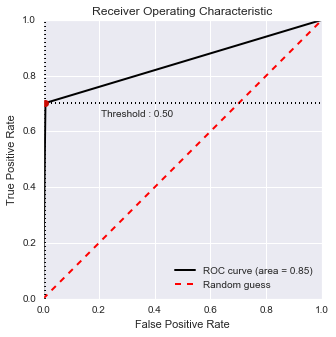

In [15]:
label_pred8 = modelo8.predict(data_test)
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo8, label_pred8)

## Extra Trees Classifier

In [16]:
modelo9=ExtraTreesClassifier(n_estimators=100, random_state=0)
modelo9.fit(data_train, label_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=0, verbose=0,
                     warm_start=False)



MATRIZ DE CONFUSION




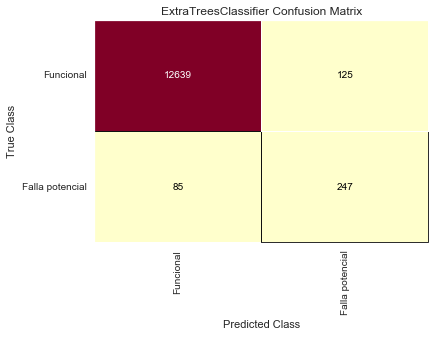



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9839645693341478
ROC AUC: 0.867091367664327
------------------------------------------------------------
Precisión por clase: [0.99331971 0.66397849]
Sensibilidad - Recall por clase: [0.99020683 0.7439759 ]
F1 por clase: [0.99176083 0.70170455]
------------------------------------------------------------
F1 Macro: 0.8467326870398904
F1 Micro: 0.9839645693341478
F1 Weighted: 0.9844075386120504
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.867091367664327
Sensibilidad - Recall Micro: 0.9839645693341478
Sensibilidad - Recall Weighted: 0.9839645693341478
------------------------------------------------------------
Precisión Macro: 0.8286491027032143
Precisión Micro: 0.9839645693341478
Precisión Weighted: 0.984970498522172
------------------------------------------------------------
Verdaderos positivos - True Positives: 247
Verdaderos negativos - True Negatives: 12639
Falsos positivos 

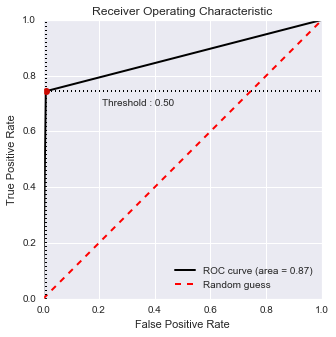

In [17]:
label_pred9 = modelo9.predict(data_test)
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo9, label_pred9)

## Gradient Boosting Classifier

In [18]:
modelo10=GradientBoostingClassifier(n_estimators=100)
modelo10.fit(data_train, label_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)



MATRIZ DE CONFUSION




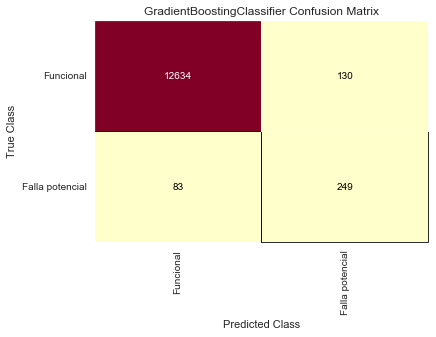



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9837354917532071
ROC AUC: 0.8699075524913821
------------------------------------------------------------
Precisión por clase: [0.9934733  0.65699208]
Sensibilidad - Recall por clase: [0.9898151 0.75     ]
F1 por clase: [0.99164083 0.70042194]
------------------------------------------------------------
F1 Macro: 0.846031385675469
F1 Micro: 0.9837354917532071
F1 Weighted: 0.9842580668832559
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.869907552491382
Sensibilidad - Recall Micro: 0.9837354917532071
Sensibilidad - Recall Weighted: 0.9837354917532071
------------------------------------------------------------
Precisión Macro: 0.8252326939423948
Precisión Micro: 0.9837354917532071
Precisión Weighted: 0.9849430831776046
------------------------------------------------------------
Verdaderos positivos - True Positives: 249
Verdaderos negativos - True Negatives: 12634
Falsos positivos -

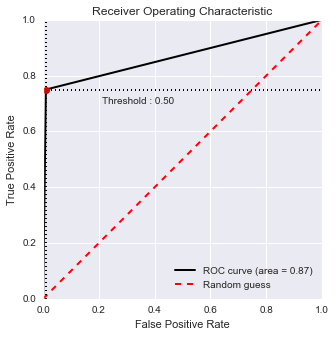

In [19]:
label_pred10 = modelo10.predict(data_test)
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo10, label_pred10)